In [1]:
import pyspark
from pyspark.mllib.stat import Statistics
from csv import reader
import pandas as pd
import numpy as np
import re
from pyproj import Proj,transform

In [2]:
# read data into RDD
data = sc.textFile('./NYPD_Complaint_Data_Historic.csv', 1) \
          .mapPartitions(lambda x: reader(x))

In [3]:
CMPLNT_NUM=0

CMPLNT_FR_DT=1
CMPLNT_FR_TM=2
CMPLNT_TO_DT=3
CMPLNT_TO_TM=4

RPT_DT=5

KY_CD=6
OFNS_DESC=7

PD_CD=8
PD_DESC=9

CRM_ATPT_CPTD_CD=10
LAW_CAT_CD=11
JURIS_DESC=12



LOC_OF_OCCUR_DESC=15
PREM_TYP_DESC=16
PARKS_NM=17
HADEVELOPT=18


BORO_NM=13
ADDR_PCT_CD=14

X_COORD_CD=19
Y_COORD_CD=20
Latitude=21
Longitude=22
Lat_Lon = 23

In [4]:
header = data.first()
data = data.filter(lambda x: x != header)

In [7]:
# Borough and Precinct Match
Borough = {'QUEENS':range(100,116), 'MANHATTAN':[1,5,6,7,9,10,13,14,17,18,19,20,22,23,24,25,26,28,30,32,33,34], 'BROOKLYN':[60,61,62,63,66,67,68,69,70,71,72,73,75,76,77,78,79,81,83,84,88,90,94], 'BRONX':list(range(40,51) ) +[52], 'STATEN ISLAND':list(range(120,124)), '':[-1]}
for key in Borough.keys():
    Borough[key] = [str(x) for x in Borough[key]] 

precictdict = {}
for key, value in Borough.items():
    for string in value:
        precictdict.setdefault(string, []).append(key)
precictdict[''] = ''

def borough_valuecheck(borough,precinct):
    '''
    check whether value in BORO_NM is a valid Borough namd and consistent with the precinct code
    '''
    if borough=='':
        return 'NULL'
    else:
        if (borough.upper() in Borough.keys()) and precinct in Borough[borough]:
            return 'Valid'
        else:
            return 'Invalid'

def precinct_valuecheck(borough,precinct):
    '''
    heck whether value in ADDR_PCT_CD is a valid Precinct ID and consistent with the Borough
    '''
    if precinct=='':
        return 'NULL'
    else:
        if (precinct in precictdict.keys()) and precinct in Borough[borough]:
            return 'Valid'
        else:
            return 'Invalid'
# Borough        
Borough_check  =  data.map(lambda x: (x[BORO_NM], 'TEXT', 'Borough name', borough_valuecheck(x[BORO_NM],x[ADDR_PCT_CD])))
# Precinct
Precinct_check  =  data.map(lambda x: (x[ADDR_PCT_CD], 'Integer', 'Precinct ID', precinct_valuecheck(x[BORO_NM],x[ADDR_PCT_CD])))


# geographic imformation match checking
def check_Projection(X_cordi,Y_cordi,latitud, longitude):
    '''
    Location information consistency under New York State Plane Coordinate System and Global Coordinate System
    Args:
       X_cordi: X_COORD_CD varible 
       Y_cordi: Y_COORD_CD varible 
       latitud: Latitude varible 
       longitude:  Longitude varible 
    Returns:
       Boolean indicator for consistency
    '''
    if X_cordi!='' and Y_cordi!='' and latitud!='' and longitude!='':
        p = Proj(init="EPSG:2263", preserve_units=True)
        lon,la = p(X_cordi,Y_cordi,inverse=True) 
        if abs(lon-float(longitude))<10e-4 and abs(la-float(latitud))<10e-4:
            return True
        else:
            return False
    else:
        return False

def check_Lat_Lon(latitud, longitude, gps_com):
    '''
    Global Coordinate System Location information consistency between latitude, longitude and Lat_Lon
    '''
    if latitud!='' and longitude!='' and gps_com!='' and '(%s, %s)' % (latitud, longitude) == gps_com:
        return True
    else:
        return False

def location_valuecheck(X_cordi,Y_cordi,latitud, longitude, gps_com, col):
    '''
    Location related variable checker. 
    Args:
      X_cordi,Y_cordi,latitud, longitude, gps_com
      col: variable indicator. Possible values: 'X':X_cordi ,'Y': Y_cordi, 'LA':latitud, 'LO':longitude, 'GPS':gps_com
    '''
    dict_missing = {'X':X_cordi ,'Y': Y_cordi, 'LA':latitud, 'LO':longitude, 'GPS':gps_com}
    if dict_missing[col]=='':
        return 'NULL'
    else:  
        if (col in ['X','Y'] and check_Projection(X_cordi,Y_cordi,latitud, longitude)) or (col in ['LA','LO'] and check_Projection(X_cordi,Y_cordi,latitud, longitude) and check_Lat_Lon(latitud, longitude,gps_com)) or (col == 'GPS' and check_Lat_Lon(latitud, longitude,gps_com)):
            return 'Valid'
        else:
            return 'Invalid'


# X_COORD_CD 
X_COORD_CD_check = data.map(lambda x: (x[X_COORD_CD],'Integer', 'X-coordinate for New York State Plane Coordinate System',
                                       location_valuecheck(x[X_COORD_CD],x[Y_COORD_CD],x[Latitude],x[Longitude],x[Lat_Lon],'X')))
# Y_COORD_CD 
Y_COORD_CD_check = data.map(lambda x: (x[Y_COORD_CD],'Integer', 'X-coordinate for New York State Plane Coordinate System',
                                       location_valuecheck(x[X_COORD_CD],x[Y_COORD_CD],x[Latitude],x[Longitude],x[Lat_Lon],'Y')))

# Latitude 
Latitude_check = data.map(lambda x:(x[Latitude],'Float','Latitude coordinate for Global Coordinate System',
                                    location_valuecheck(x[X_COORD_CD],x[Y_COORD_CD],x[Latitude],x[Longitude],x[Lat_Lon],'LA')))
# Longitude
Longitude_check = data.map(lambda x:(x[Longitude],'Float','Longitude coordinate for Global Coordinate System',
                                    location_valuecheck(x[X_COORD_CD],x[Y_COORD_CD],x[Latitude],x[Longitude],x[Lat_Lon],'LO')))
#Lat_Lon
Lat_Lon_check = data.map(lambda x:(x[Lat_Lon],'Location','Location in Global Coordinate System',
                                    location_valuecheck(x[X_COORD_CD],x[Y_COORD_CD],x[Latitude],x[Longitude],x[Lat_Lon],'GPS')))


def text_valuecheck(text):
    if text=='' or text==' ':
        return 'NULL'
    else:
        return 'Valid'

# PARKS_NM
PARKS_NM_check = data.map(lambda x:(x[PARKS_NM],'TEXT','Name of NYC park, playground or greenspace',text_valuecheck(x[PARKS_NM])))
# PREM_TYP_DESC
PREM_TYP_DESC_check = data.map(lambda x:(x[PREM_TYP_DESC],'TEXT','Specific description of premises',text_valuecheck(x[PREM_TYP_DESC])))
# LOC_OF_OCCUR_DESC
LOC_OF_OCCUR_DESC_check = data.map(lambda x:(x[LOC_OF_OCCUR_DESC],'TEXT','Specific location of occurrence in or around the premises',text_valuecheck(x[LOC_OF_OCCUR_DESC])))
# HADEVELOPT
HADEVELOPT_check = data.map(lambda x:(x[HADEVELOPT],'TEXT','Name of NYCHA housing development',text_valuecheck(x[HADEVELOPT])))


In [5]:
def text_valuecheck(text):
    if text=='' or text==' ':
        return 'NULL'
    else:
        return 'Valid'

# PARKS_NM
PARKS_NM_check = data.map(lambda x:(x[PARKS_NM],'TEXT','Name of NYC park, playground or greenspace',text_valuecheck(x[PARKS_NM])))
# PREM_TYP_DESC
PREM_TYP_DESC_check = data.map(lambda x:(x[PREM_TYP_DESC],'TEXT','Specific description of premises',text_valuecheck(x[PREM_TYP_DESC])))
# LOC_OF_OCCUR_DESC
LOC_OF_OCCUR_DESC_check = data.map(lambda x:(x[LOC_OF_OCCUR_DESC],'TEXT','Specific location of occurrence in or around the premises',text_valuecheck(x[LOC_OF_OCCUR_DESC])))
# HADEVELOPT
HADEVELOPT_check = data.map(lambda x:(x[HADEVELOPT],'TEXT','Name of NYCHA housing development',text_valuecheck(x[HADEVELOPT])))


In [7]:
summary_validation(PARKS_NM_check,'PARKS_NM_check')

PARKS_NM_check
NULL: 5093632
Invalid: 0


In [8]:
summary_validation(PREM_TYP_DESC_check,'PREM_TYP_DESC_check')

PREM_TYP_DESC_check
NULL: 33279
Invalid: 0


In [9]:
summary_validation(LOC_OF_OCCUR_DESC_check,'LOC_OF_OCCUR_DESC_check')

LOC_OF_OCCUR_DESC_check
NULL: 1127341
Invalid: 0


In [10]:
summary_validation(HADEVELOPT_check ,'HADEVELOPT_check ')

HADEVELOPT_check 
NULL: 4848026
Invalid: 0


# Data Summary

In [6]:
def summary_validation(variable,name):
    print(name)
    print('NULL:',variable.filter(lambda x:x[3]=='NULL').count())
    print('Invalid:',variable.filter(lambda x:x[3]=='Invalid').count())
name='X_COORD_CD_check,Y_COORD_CD_check,Latitude_check,Longitude_check,Lat_Lon_check,Borough_check,Precinct_check'.split(',')
variable = [X_COORD_CD_check,Y_COORD_CD_check,Latitude_check,Longitude_check,Lat_Lon_check,Borough_check,Precinct_check]

#for i in range(len(name)):
#    summary_validation(variable[i],name[i])

NameError: name 'X_COORD_CD_check' is not defined

## Unique Value 

In [11]:
def count_occurence(colnum):
    # count occurences of boroughs
    count_occurence = data.map(lambda x: x[colnum]) \
                          .countByValue()
    return pd.DataFrame(list(count_occurence.items()), columns=[header[colnum],'count']).sort_values(by='count', ascending=False)

variable = [LOC_OF_OCCUR_DESC, PREM_TYP_DESC, PARKS_NM, HADEVELOPT]
name = 'LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM, HADEVELOPT'.split(',')

uniqueValue_tables=dict()
uniqueValue_count=dict()
for i in range(len(variable)):
    uniqueValue_tables[name[i]] = count_occurence(variable[i])
    uniqueValue_count[name[i]] = len(uniqueValue_tables[name[i]])

In [92]:
uniqueValue_tables['PARKS_NM']

,PARKS_NM,count
0,,5093632
645,CENTRAL PARK,543
818,FLUSHING MEADOWS CORONA PARK,301
14,RIVERSIDE PARK,188
522,ST. MARY'S PARK BRONX,143
599,MARCUS GARVEY PARK,137
537,CONEY ISLAND BEACH & BOARDWALK,136
753,CLAREMONT PARK,134
43,MACOMBS DAM PARK,122
420,VAN CORTLANDT PARK,114


## Inconsistency between BORO_NM and ADDR_PCT_CD

In [8]:
# Borough and Precinct Conflict check
Bo_pre_con = data.filter(lambda x: x[ADDR_PCT_CD] not in Borough[x[BORO_NM]]).map(lambda x: (x[ADDR_PCT_CD],x[BORO_NM]))

In [9]:
# create a new borough column according to the precinct code
BORN_NM_FROM_PCT = data.map(lambda x: (x[ADDR_PCT_CD], precictdict[x[ADDR_PCT_CD]]) if x[BORO_NM]=='' else (x[ADDR_PCT_CD],x[BORO_NM]))

In [10]:
Bo_pre_con.filter(lambda x: x[0]!='').map(lambda x: x[0]).countByValue()

defaultdict(int,
            {'100': 1,
             '104': 2,
             '106': 1,
             '114': 2,
             '121': 75,
             '13': 1,
             '14': 1,
             '23': 3,
             '25': 1,
             '26': 1,
             '34': 1,
             '6': 1,
             '7': 1,
             '71': 1,
             '9': 1})

# Piechart 

### LOC_OF_OCCUR_DESC


In [29]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r,g,b = tableau20[i]
    tableau20[i] = (r/255., g/255., b/255.)
    
from pylab import *

plt.style.use('ggplot')
plt.figure(figsize=(10,7.5))

data_pie = uniqueValue_tables['LOC_OF_OCCUR_DESC'][uniqueValue_tables['LOC_OF_OCCUR_DESC']['LOC_OF_OCCUR_DESC']!=''][:-1]
pie(data_pie['count'], 
    #explode=(0.02,0.02,0.02), 
    shadow=True, 
    #startangle=90, 
    autopct='%1.1f%%', 
    labels=data_pie.LOC_OF_OCCUR_DESC,
    colors=tableau20,
    );
#plt.axis('equal',fontsize=20)
plt.title('LOC_OF_OCCUR_DESC - \n Location of occurrence in or around the premises',fontsize=15)#

NameError: name 'uniqueValue_tables' is not defined

In [ ]:
# between Hour / Week and 

In [31]:
premise = data.map(lambda x: [x[PREM_TYP_DESC],x[CMPLNT_FR_DT],x[CMPLNT_FR_TM]]).countByValue()

In [ ]:
premise = pd.DataFrame(list(premise.items()), columns=[header[CMPLNT_FR_DT],header[CMPLNT_FR_TM],'count']).sort_values(by='count', ascending=False)

In [93]:
# plot by date

In [11]:
date = data.map(lambda x:x[CMPLNT_FR_DT]).countByValue()

In [12]:
date_df = pd.DataFrame(list(date.items()), columns=[header[CMPLNT_FR_DT],'count']).sort_values(by='count', ascending=False)

In [13]:
import datetime
date_df = date_df[date_df.CMPLNT_FR_DT!='']
date_df['date'] = list(map(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"),date_df.CMPLNT_FR_DT))

In [14]:
date_df = date_df[date_df.date > datetime.datetime.strptime('01/01/2006', "%m/%d/%Y")]

In [15]:
date_df = date_df.sort(['date'])

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [16]:
date_df.index = date_df.date
monthly_df = date_df.resample('M').sum()
month_short = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}
monthly_df['Month']=list(map(lambda x: month_short[x.month],monthly_df.index))

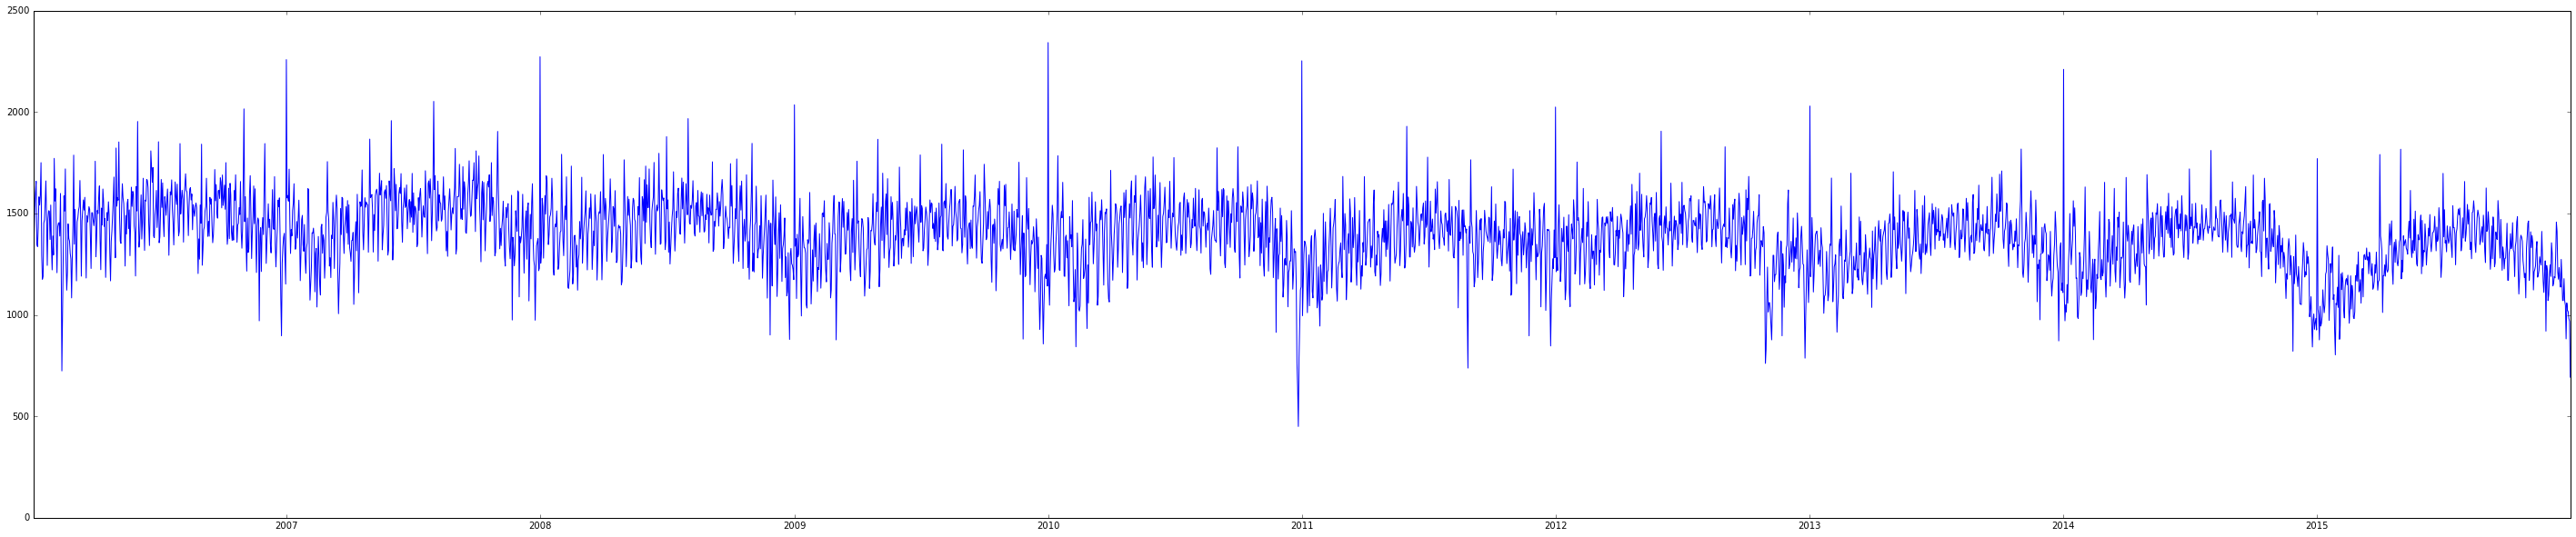

In [19]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(50,10))
plt.plot_date(x=date_df.date, y=date_df['count'], fmt="b-")

In [23]:
date_df['Weekday']=list(map(lambda x: x.weekday(),date_df.index))
date_df['Month']=list(map(lambda x: x.month,date_df.index))
#date_df.index.weekday

NameError: name 'arange' is not defined

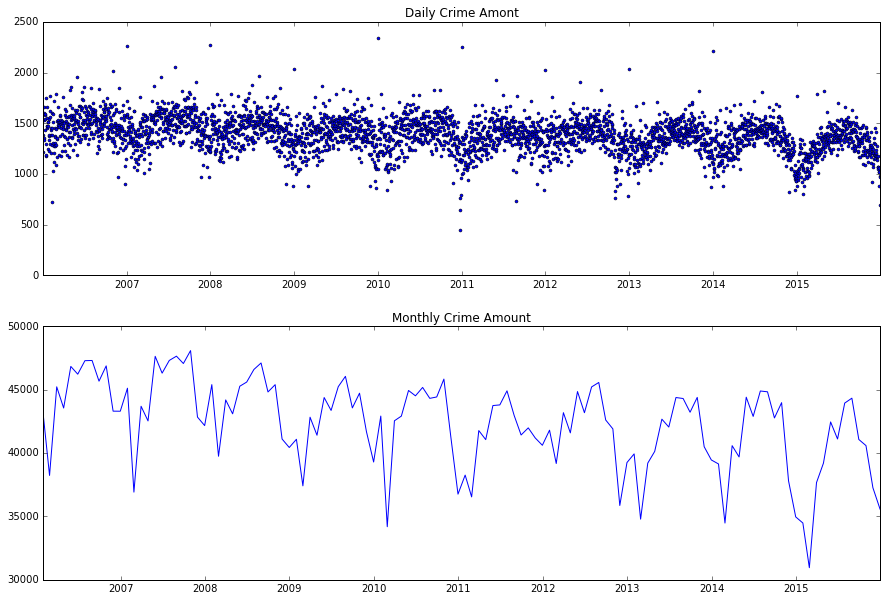

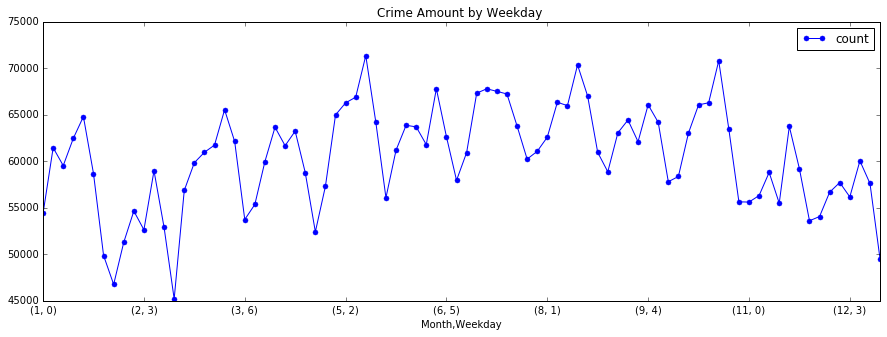

In [28]:
plt.figure(1)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot_date(x=date_df.date, y=date_df['count'], markersize = 3)
plt.title('Daily Crime Amont')

plt.subplot(212)
plt.plot(monthly_df['count'], markersize = 8)
plt.title('Monthly Crime Amount')

plt.subplot(211)
weekbymonth.plot(figsize=(15,5),markersize = 10,marker = '.')
#locs, labels = xticks()
plt.title('Crime Amount by Weekday ')
plt.xticks(arange(12*7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun']*12,rotation=90, fontsize=10)

plt.show()




In [25]:
weekbymonth = pd.DataFrame(date_df.groupby(['Month','Weekday'])['count'].sum())

In [26]:
weekbymonth['Week'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']*12